## Integrantes:
## Acosta Imandt Daniel
## Garduño Martínez Eduardo
## Castillo Del Valle Pablo David

## Introducción

Nosotros vamos a observar una base de datos sobre medicamentos que fueron recetados  para ciertas condiciones junto una pequeña nota de los síntomas.
Estamos interesados en utilizar índiceinverso para encontrar pares similares de las reseñas de los síntomas, para esto se utilizaron las funciones de similitud Jaccard, Coseno y minmax . Esto para encontrar si pacientes tuvieron síntomas similares y ver que se le receto y que se le diagnóstico en cada caso.Esto tiene una gran cantidad de aplicaciones para consultas médicas, ya que esto puede ayudar a los doctores a tomar mejores decisiones para futuros diagnósticos.

## Requisitos

In [ ]:
#Descargamos los modulos que vamos a usar
!pip install nltk
!pip install --upgrade pip
!python -m nltk.downloader all

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_

In [ ]:
#Importamos los modulos que vamos a usar
from collections import  Counter
import re
import codecs
import pandas as pd
from math import log
import numpy as np
import time

VOCMAX = 15000

In [ ]:
#importamos las biblioteca de procesamiento de lenguaje natural asi como el lematizador y el analizador lexico
import nltk
nltk.download(['punkt','averaged_perceptron_tagger','wordnet'])

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ

morphy_tag = {
    'JJ' : ADJ,
    'JJR' : ADJ,
    'JJS' : ADJ,
    'VB' : VERB,
    'VBD' : VERB,
    'VBG' : VERB,
    'VBN' : VERB,
    'VBP' : VERB,
    'VBZ' : VERB,
    'RB' : ADV,
    'RBR' : ADV,
    'RBS' : ADV
}

def doc_a_tokens(doc):
  tagged = pos_tag(word_tokenize(doc.lower()))
  lemmatizer = WordNetLemmatizer()
  tokens = []
  for p,t in tagged:
    tokens.append(lemmatizer.lemmatize(p, pos=morphy_tag.get(t, NOUN)))

  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocesamiento

In [ ]:
#Carga de los datos
df = pd.read_csv("drugsComTrain_raw.csv")
df = pd.DataFrame(df[["review","drugName","condition"]])
df

,review,drugName,condition
0,"""It has no side effect, I take it in combinati...",Valsartan,Left Ventricular Dysfunction
1,"""My son is halfway through his fourth week of ...",Guanfacine,ADHD
2,"""I used to take another oral contraceptive, wh...",Lybrel,Birth Control
3,"""This is my first time using any form of birth...",Ortho Evra,Birth Control
4,"""Suboxone has completely turned my life around...",Buprenorphine / naloxone,Opiate Dependence
...,...,...,...
161292,"""I wrote my first report in Mid-October of 201...",Campral,Alcohol Dependence
161293,"""I was given this in IV before surgey. I immed...",Metoclopramide,Nausea/Vomiting
161294,"""Limited improvement after 4 months, developed...",Orencia,Rheumatoid Arthritis
161295,"""I&#039;ve been on thyroid medication 49 years...",Thyroid desiccated,Underactive Thyroid


In [ ]:
#Guardamos las stopwords

!wget -qO- -O stopwords_english.txt \
         https://raw.githubusercontent.com/pan-webis-de/authorid/master/data/stopwords_english.txt

stopwords = []
for line in codecs.open('stopwords_english.txt', encoding = "utf-8"):
  stopwords.append(line.rstrip())

s = ["day","week","year","month"]

for j in s:
    stopwords.append(j.rstrip())

### Preprocesamiento Texto

In [ ]:
#En esta sección voy a quitar los &#039; que en realidad es una '
for j,c in enumerate(df.review):
    df.at[j,"review"] = c.replace("&#039;"," ")

for j,c in enumerate(df.review):
    df.at[j,"review"] = c.replace("&quot;","")

In [ ]:
corpus_review = []
for d in df.review:
  d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
  d = ' '.join([''.join([c.lower() for c in p if c.isalnum()]) for p in d.split()])
  tokens_review = doc_a_tokens(d)
  corpus_review.append(' '.join(tokens_review))

In [ ]:
# Divide la cadena en palabras
term_re_review = re.compile("\w+", re.UNICODE)

# Contamos las ocurrencias de cada palabra
corpus_freq_review = Counter()
doc_freq_review = Counter()
for d in corpus_review:
  # Eliminamos números de la cadena (documento) a procesar
  d = re.sub(r'\d+', '', d)

  # Dividimos la cadena en una lista de palabras
  terms_review = [t for t in term_re_review.findall(d) if t not in stopwords and len(t) > 2]

  # Aumentamos el contador de cada instancia palabra en el documento
  for t in terms_review:
    corpus_freq_review[t] += 1

  # Aumentamos el contador de cada palabra distinta en el documento
  for t in set(terms_review):
    doc_freq_review[t] += 1

# Generamos un diccionario con las VOCMAX palabras más frecuentes
vocabulary_review = {entry[0]:(i, entry[1], doc_freq_review[entry[0]], log(len(corpus_review) / doc_freq_review[entry[0]])) \
              for i, entry in enumerate(corpus_freq_review.most_common()) \
              if i < VOCMAX}

In [ ]:
#Guardamos las ids de las palabras
id_a_palabra_review = {v[0]: k for k,v in vocabulary_review.items()}

In [ ]:
#Creacion de las bolsas de las review
bolsas_review = []
for d in corpus_review:
  d = re.sub(r'\d+', '', d)
  ids = Counter([vocabulary_review[t][0] for t in term_re_review.findall(d) \
                 if t in vocabulary_review and t not in stopwords])
  bolsas_review.append([i for i in sorted(ids.items())])

### Preprocesamiento Medicamento

In [ ]:
#Quitamos caracteres inesarios
a = ["Fe ","/ ",".","\d"]
for j,c in enumerate(df.drugName):
    df.at[j,"drugName"] = c.replace("Fe ","")

for j,c in enumerate(df.drugName):
    df.at[j,"drugName"] = c.replace("/ ","")

for j,c in enumerate(df.drugName):
    df.at[j,"drugName"] = c.replace(".","")

for j,c in enumerate(df.drugName):
    df.at[j,"drugName"] = re.sub("\d","",c)

In [ ]:
corpus_drugs = []
for d in df.drugName:
  d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
  d = ' '.join([''.join([c.lower() for c in p if c.isalnum()]) for p in d.split()])
  tokens_drugs = doc_a_tokens(d)
  corpus_drugs.append(' '.join(tokens_drugs))

In [ ]:
# Divide la cadena en palabras
term_re_drugs = re.compile("\w+", re.UNICODE)

# Contamos las ocurrencias de cada palabra
corpus_freq_drugs = Counter()
doc_freq_drugs = Counter()
for d in corpus_drugs:
  # Eliminamos números de la cadena (documento) a procesar
  d = re.sub(r'\d+', '', d)

  # Dividimos la cadena en una lista de palabras
  terms_drugs = [t for t in term_re_drugs.findall(d) if t not in stopwords and len(t) > 2]

  # Aumentamos el contador de cada instancia palabra en el documento
  for t in terms_drugs:
    corpus_freq_drugs[t] += 1

  # Aumentamos el contador de cada palabra distinta en el documento
  for t in set(terms_drugs):
    doc_freq_drugs[t] += 1

# Generamos un diccionario con las VOCMAX palabras más frecuentes
vocabulary_drugs = {entry[0]:(i, entry[1], doc_freq_drugs[entry[0]], log(len(corpus_drugs) / doc_freq_drugs[entry[0]])) \
              for i, entry in enumerate(corpus_freq_drugs.most_common()) \
              if i < VOCMAX}

In [ ]:
#Guardamos las ids de las palabras
id_a_palabra_drugs = {v[0]: k for k,v in vocabulary_drugs.items()}

In [ ]:
#Creacion de las bolsas de las medicinas
bolsas_drugs = []
for d in corpus_drugs:
  d = re.sub(r'\d+', '', d)
  ids = Counter([vocabulary_drugs[t][0] for t in term_re_drugs.findall(d) \
                 if t in vocabulary_drugs and t not in stopwords])
  bolsas_drugs.append([i for i in sorted(ids.items())])

### Preprocesamiento Condición

In [ ]:
df["condition"] = df["condition"].fillna("No Información")

In [ ]:
corpus_condition = []
for d in df.condition:
  d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
  d = ' '.join([''.join([c.lower() for c in p if c.isalnum()]) for p in d.split()])
  tokens_condition = doc_a_tokens(d)
  corpus_condition.append(' '.join(tokens_condition))

In [ ]:
# Divide la cadena en palabras
term_re_condition = re.compile("\w+", re.UNICODE)

# Contamos las ocurrencias de cada palabra
corpus_freq_condition = Counter()
doc_freq_condition = Counter()
for d in corpus_condition:
  # Eliminamos números de la cadena (documento) a procesar
  d = re.sub(r'\d+', '', d)

  # Dividimos la cadena en una lista de palabras
  terms_condition = [t for t in term_re_drugs.findall(d) if t not in stopwords and len(t) > 2]

  # Aumentamos el contador de cada instancia palabra en el documento
  for t in terms_condition:
    corpus_freq_condition[t] += 1

  # Aumentamos el contador de cada palabra distinta en el documento
  for t in set(terms_condition):
    doc_freq_condition[t] += 1

# Generamos un diccionario con las VOCMAX palabras más frecuentes
vocabulary_condition = {entry[0]:(i, entry[1], doc_freq_condition[entry[0]], log(len(corpus_condition) / doc_freq_condition[entry[0]])) \
              for i, entry in enumerate(corpus_freq_condition.most_common()) \
              if i < VOCMAX}

In [ ]:
#Guardamos las ids de las palabras
id_a_palabra_condition = {v[0]: k for k,v in vocabulary_condition.items()}

In [ ]:
#Creacion de las bolsas de la condition
bolsas_condition = []
for d in corpus_condition:
  d = re.sub(r'\d+', '', d)
  ids = Counter([vocabulary_condition[t][0] for t in term_re_condition.findall(d) \
                 if t in vocabulary_condition and t not in stopwords])
  bolsas_condition.append([i for i in sorted(ids.items())])

## Clases y funciones

In [ ]:
#Funcion de similitud coseno
def similitud_coseno(x, y):
  ax = np.zeros(VOCMAX)
  for e in x:
    ax[e[0]] = e[1] * vocabulary_review[id_a_palabra_review[e[0]]][-1]

  ay = np.zeros(VOCMAX)
  for e in y:
    ay[e[0]] = e[1] * vocabulary_review[id_a_palabra_review[e[0]]][-1]

  pnorma = (np.sqrt(ax @ ax) * np.sqrt(ay @ ay))

  if pnorma > 0:
    return (ax @ ay) / pnorma
  else:
    return np.nan

In [ ]:
#Funcion de similitud jaccard
def similitud_jaccard(x, y):
  ax = np.zeros(VOCMAX)
  for e in x:
    ax[e[0]] = 1

  ay = np.zeros(VOCMAX)
  for e in y:
    ay[e[0]] = 1

  inter = np.count_nonzero(ax * ay)
  return inter / (np.count_nonzero(ax) + np.count_nonzero(ay) - inter)

#Funcion de similitud minmax
def similitud_minmax(x, y):
  ax = np.zeros(VOCMAX)
  for e in x:
    ax[e[0]] = e[1]

  ay = np.zeros(VOCMAX)
  for e in y:
    ay[e[0]] = e[1]

  c = np.vstack((ax,ay))
  mn = np.sum(np.min(c, axis=0))
  mx = np.sum(np.max(c, axis=0))
  return mn / mx

In [ ]:
from more_itertools import sort_together

In [ ]:
#Clase de indice inverso vista en clase con modificaciones
class IndiceInverso:
    def  __getitem__(self, idx):
        return self.ifs[idx]

    def __repr__(self):
        contenido = ['%d::%s' % (i, self.ifs[i]) for i in range(len(self.ifs))]
        return "<IFS :%s >" % ('\n'.join(contenido))

    def __str__(self):
        contenido = ['%d::%s' % (i, self.ifs[i]) for i in range(len(self.ifs))]
        return '\n'.join(contenido)


    def recupera(self, medicamento = None, resena = None, No_consultas = 1,similitud = None, enfermedad = None):
        if medicamento is None and enfermedad is None:
            if resena is None:
                return "Ingrese una reseña"
            else:
                resul = Counter([j for (i,_) in resena for j in self.ifs_resena[i]])
                if similitud is None:
                    if No_consultas == 1:
                        bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                        bolsa_dc = [b for i,b in enumerate(resena)]
                        medidas = np.zeros(len(bolsas_review))
                        for (i,x) in bolsas_base:
                            medidas[i] = resul[i]
                        return [np.nanmax(medidas), np.nanargmax(medidas),len(bolsas_base)]

                    else:
                        return resul.most_common(No_consultas)

                elif similitud == "Jaccard":
                    bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                    bolsa_dc = [b for i,b in enumerate(resena)]
                    medidas = np.zeros(len(bolsas_review))
                    for (i,x) in bolsas_base:
                        medidas[i] = similitud_jaccard(x,bolsa_dc)
                    return [np.nanmax(medidas), np.nanargmax(medidas)]

                elif similitud == "Minmax":
                    bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                    bolsa_dc = [b for i,b in enumerate(resena)]
                    medidas = np.zeros(len(bolsas_review))
                    for (i,x) in bolsas_base:
                        medidas[i] = similitud_minmax(x,bolsa_dc)
                    return [np.nanmax(medidas), np.nanargmax(medidas)]

                elif similitud == "Coseno":
                    bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                    bolsa_dc = [b for i,b in enumerate(resena)]
                    medidas = np.zeros(len(bolsas_review))
                    for (i,x) in bolsas_base:
                        medidas[i] = similitud_coseno(x,bolsa_dc)
                    return [np.nanmax(medidas), np.nanargmax(medidas)]

                else:
                    return "Ingrese una similitud correcta"

        if medicamento is None:
            a = [j for (i,_) in enfermedad for j in self.ifs_enfermedad[i]]
            if len(a) == 0:
                return "No se encontraron resultados"
            else:
                resul = Counter([j for (i,_) in resena for j in self.ifs_resena[i] if j in a])
                if similitud is None:
                    if No_consultas == 1:
                        bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                        bolsa_dc = [b for i,b in enumerate(resena)]
                        medidas = np.zeros(len(bolsas_review))
                        for (i,x) in bolsas_base:
                            medidas[i] = resul[i]
                        return [np.nanmax(medidas), np.nanargmax(medidas),len(bolsas_base)]

                    else:
                        return resul.most_common(No_consultas)

                elif similitud == "Jaccard":
                    bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                    bolsa_dc = [b for i,b in enumerate(resena)]
                    medidas = np.zeros(len(bolsas_review))
                    for (i,x) in bolsas_base:
                        medidas[i] = similitud_jaccard(x,bolsa_dc)
                    return [np.nanmax(medidas), np.nanargmax(medidas)]

                elif similitud == "Minmax":
                    bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                    bolsa_dc = [b for i,b in enumerate(resena)]
                    medidas = np.zeros(len(bolsas_review))
                    for (i,x) in bolsas_base:
                        medidas[i] = similitud_minmax(x,bolsa_dc)
                    return [np.nanmax(medidas), np.nanargmax(medidas)]

                elif similitud == "Coseno":
                    bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                    bolsa_dc = [b for i,b in enumerate(resena)]
                    medidas = np.zeros(len(bolsas_review))
                    for (i,x) in bolsas_base:
                        medidas[i] = similitud_coseno(x,bolsa_dc)
                    return [np.nanmax(medidas), np.nanargmax(medidas)]

                else:
                    return "Ingrese una similitud correcta"


        if enfermedad is None:
            b = [j for (i,_) in medicamento for j in self.ifs_medicamento[i]]
            if len(b) == 0:
                return "No se encontraron resultados"
            else:
                resul =  Counter([j for (i,_) in resena for j in self.ifs_resena[i] if j in b])
                if similitud is None:
                    if No_consultas == 1:
                        bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                        bolsa_dc = [b for i,b in enumerate(resena)]
                        medidas = np.zeros(len(bolsas_review))
                        for (i,x) in bolsas_base:
                            medidas[i] = resul[i]
                        return [np.nanmax(medidas), np.nanargmax(medidas),len(bolsas_base)]

                    else:
                        return resul.most_common(No_consultas)

                elif similitud == "Jaccard":
                    bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                    bolsa_dc = [b for i,b in enumerate(resena)]
                    medidas = np.zeros(len(bolsas_review))
                    for (i,x) in bolsas_base:
                        medidas[i] = similitud_jaccard(x,bolsa_dc)
                    return [np.nanmax(medidas), np.nanargmax(medidas)]

                elif similitud == "Minmax":
                    bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                    bolsa_dc = [b for i,b in enumerate(resena)]
                    medidas = np.zeros(len(bolsas_review))
                    for (i,x) in bolsas_base:
                        medidas[i] = similitud_minmax(x,bolsa_dc)
                    return [np.nanmax(medidas), np.nanargmax(medidas)]

                elif similitud == "Coseno":
                    bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                    bolsa_dc = [b for i,b in enumerate(resena)]
                    medidas = np.zeros(len(bolsas_review))
                    for (i,x) in bolsas_base:
                        medidas[i] = similitud_coseno(x,bolsa_dc)
                    return [np.nanmax(medidas), np.nanargmax(medidas)]

                else:
                    return "Ingrese una similitud correcta"

        a = [j for (i,k) in enfermedad for j in self.ifs_enfermedad[i]]
        b = [j for (i,k) in medicamento for j in self.ifs_medicamento[i]]
        c = [j for j in a if j in b]
        if len(c) == 0:
            return "No se encontraron resultado"

        resul =  Counter([j for (i,_) in resena for j in self.ifs_resena[i] if j in c])

        if similitud is None:
            if No_consultas == 1:
                bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
                bolsa_dc = [b for i,b in enumerate(resena)]
                medidas = np.zeros(len(bolsas_review))
                for (i,x) in bolsas_base:
                    medidas[i] = resul[i]
                return [np.nanmax(medidas), np.nanargmax(medidas),len(bolsas_base)]

            else:
                return resul.most_common(No_consultas)

        elif similitud == "Jaccard":
            bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
            bolsa_dc = [b for i,b in enumerate(resena)]
            medidas = np.zeros(len(bolsas_review))
            for (i,x) in bolsas_base:
                medidas[i] = similitud_jaccard(x,bolsa_dc)
            return [np.nanmax(medidas), np.nanargmax(medidas),len(bolsas_base)]

        elif similitud == "Minmax":
            bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
            bolsa_dc = [b for i,b in enumerate(resena)]
            medidas = np.zeros(len(bolsas_review))
            for (i,x) in bolsas_base:
                medidas[i] = similitud_minmax(x,bolsa_dc)
            return [np.nanmax(medidas), np.nanargmax(medidas),len(bolsas_base)]

        elif similitud == "Coseno":
            bolsas_base = [(i,b) for i,b in enumerate(bolsas_review) if resul[i] != 0]
            bolsa_dc = [b for i,b in enumerate(resena)]
            medidas = np.zeros(len(bolsas_review))
            for (i,x) in bolsas_base:
                medidas[i] = similitud_coseno(x,bolsa_dc)
            return [np.nanmax(medidas), np.nanargmax(medidas),len(bolsas_base)]

        else:
            return "Ingrese una similitud correcta"



    def construye(self, resenas, medicamento, enfermedad,tvoc):

        self.tvoc = tvoc

        self.ifs_resena = [[] for _ in range(tvoc)]
        for i,d in enumerate(resenas):
            for p in d:
                self.ifs_resena[p[0]].append(i)

        self.ifs_medicamento = [[] for _ in range(tvoc)]
        for i,d in enumerate(medicamento):
            for p in d:
                self.ifs_medicamento[p[0]].append(i)

        self.ifs_enfermedad = [[] for _ in range(tvoc)]
        for i,d in enumerate(enfermedad):
            for p in d:
                self.ifs_enfermedad[p[0]].append(i)


## Consultas

In [ ]:
#Instanciamos la clase con las bolsas de cada columna
ifs = IndiceInverso()
ifs.construye(bolsas_review,bolsas_drugs,bolsas_condition,VOCMAX)

In [ ]:
#Creamos los valores de las consultas en las distintas columnas con las palabras clave

sintomas = ["oral contraceptive horrible vomit horrible nausea and headache","happy product absolutely recommend","bipolar disorder recovery","forgetting remember dreams blood pressure"]
medicamento = ["ethinyl estradiol etonogestrel","blisovi","lamotrigine","genvoya"]
padecimiento = ["birth control","birth control","bipolar disorder","hiv infection"]

In [ ]:
#Creamos las bolsas de las palabras claves de las consultas para los distintos parametros

bolsas_consultas_review = []
for c in sintomas:
    c = re.sub(r'\d+', '', c)
    ids = Counter([vocabulary_review[t][0] for t in term_re_review.findall(c) \
                if t not in stopwords and vocabulary_review[t][0] < VOCMAX])
    bolsas_consultas_review.append([i for i in sorted(ids.items())])

bolsas_consultas_drugs = []
for c in medicamento:
    c = re.sub(r'\d+', '', c)
    ids = Counter([vocabulary_drugs[t][0] for t in term_re_drugs.findall(c) \
                    if t not in stopwords and vocabulary_drugs[t][0] < VOCMAX])
    bolsas_consultas_drugs.append([i for i in sorted(ids.items())])

bolsas_consultas_condition = []
for c in padecimiento:
    c = re.sub(r'\d+', '', c)
    ids = Counter([vocabulary_condition[t][0] for t in term_re_condition.findall(c) \
                    if t not in stopwords and vocabulary_condition[t][0] < VOCMAX])
    bolsas_consultas_condition.append([i for i in sorted(ids.items())])

In [ ]:
n = 10

### Consultas sin similitud

In [ ]:
#Consulta donde nos interesan el medicamento y la condition para la primer consulta  3033
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[0],bolsas_consultas_review[0],3,None,bolsas_consultas_condition[1])
print(r)

#Resultado 1
#print(df.review[r[1]])
print(df.review[r[1][0]])

#Resultado 2
print(df.review[r[1][0]])

#Resultado 3
print(df.review[r[2][0]])
tf = time.time()
tf1ss = tf-t0
print(tf1ss/n)

[(10048, 4), (80267, 4), (83600, 4)]
"I recently started taking Blisovi Fe 1.5/30 and my experience has been awful! I started taking it to regulate my periods. I have had minor headaches, lots of fatigue and nausea, I was vomiting towards the end of finishing my first pack (horrible) I can t sleep at all, I find myself staying up until about 5 or 6 am until I force myself to lay down and sleep because if not I could stay up all night! I have abdominal pain sometimes &amp; I have lost my appetite &amp; trust me I like to eat. I have been sick for a total of about 3 weeks &amp; a day now &amp; things are starting to concern me. I know it says that irregular bleeding is normal, but being on your period for 2 weeks with semi heavy bleeding? I don t think so...."
"I recently started taking Blisovi Fe 1.5/30 and my experience has been awful! I started taking it to regulate my periods. I have had minor headaches, lots of fatigue and nausea, I was vomiting towards the end of finishing my first

In [ ]:
#Consulta donde nos interesa solo la condición para la primer consulta    7035
t0 = time.time()
for j in range(n):
    r = ifs.recupera(None,bolsas_consultas_review[0],3,None,bolsas_consultas_condition[1])
print(r)

#Resultado 1
print(df.review[r[0][0]])
#print(df.review[r[1]])

#Resultado 2
print(df.review[r[1][0]])

#Resultado 3
print(df.review[r[2][0]])

tf = time.time()
print((tf-t0)/n)

[(9834, 4), (10048, 4), (27274, 4)]
"I ve been taking this medication for a one week, 2 days now. I was scared to take it at first because I have never taken an oral contraceptive before. I was on the patch and it was a nightmare. But this medication sits pretty well with me. I get a little nausea from time to time but nothing major. Occasionally a headache and mild cramps. (these symptoms aren t normal for me so that s how I know its the medication). I ve also have my period for as long as I been taking it but it s very light. Hopefully my body will get used to it soon. Oh and I haven t any mood swings."
"I m on my third week of Sprintec 28 and haven t had a single negative side effect. I started using it on the first day of my period which also happened to be a Sunday (lucky me). I love it! As long as there s no side effects and nothing changes then I m staying on this pill forever. The only thing I noticed is that there was still light bleeding even after my period ended but nothing

In [ ]:
#Consulta donde no nos intersa ni la condición ni el medicamento para la primer consulta 29818
t0 = time.time()
for j in range(n):
    r = ifs.recupera(None,bolsas_consultas_review[0],3,None,None)
print(r)

#Resultado 1
print(df.review[r[0][0]])
#print(df.review[r[1]])

#Resultado 2
print(df.review[r[1][0]])

#Resultado 3
print(df.review[r[2][0]])

tf = time.time()
print((tf-t0)/n)

[(3199, 4), (4319, 4), (4770, 4)]
"I have a horrible stomach virus and I am 8 weeks pregnant. I wasn t able to keep any fluids down for over 12 hours. I was given IV fluid, and 2 doses of zofran (same thing) and the nausea went away withing 10-15 mins! The doctor prescribed me the tablets that dissolve and within the same amount of time my nausea goes away. I m able to drink water, even take a few bites of bread which is a lot. This is heaven sent. I do get headaches easily so that s the only downfall, but it s way better then vomiting."
"The sickest six weeks of my life. Constant nausea accompanied by intermittent vomiting, headaches and flu-like symptoms.  I would have  had to die to feel better.  An emotional wreck, severe bouts of crying, feelings of utter despondency and hopelessness that were not present before taking.  I am amazed that this drug made it through the FDA with such high incidences of nausea.  Absolutely horrible experience."
"I have endometriosis on my bowel and se

In [ ]:
#Segunda consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[1],bolsas_consultas_review[1],1,None,bolsas_consultas_condition[1])
print(r)
print(df.review[r[1]])
tf = time.time()
tf2ss = tf-t0
print(tf2ss/n)

[2.0, 22748, 39]
"So I started taking this BC when Gildess got discontinued. Up until that point I had absolutely no problems for the almost 2 years I was taking Gildess. After switching to Blisovi though, I ve had slightly more cramping, tender breasts, and gained about 15 pounds. I ve been the same weight for 5 years and all the sudden, I ve gained all this weight. I m just now connecting it to the BC after reading reviews of the same thing happening to others. My periods are very light, and last no more than 3 days.  Overall, not happy with this BC."
0.3291862726211548


In [ ]:
#Tercer consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[2],bolsas_consultas_review[2],3,None,bolsas_consultas_condition[2])
print(df.review[r[0][0]])
tf = time.time()
tf3ss = tf-t0
print(tf3ss/n)

"Excellent medication for bipolar disorder although I had a reaction to it."
0.17155678272247316


In [ ]:
#Cuarta consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[3],bolsas_consultas_review[3],3,None,bolsas_consultas_condition[3])
print(df.review[r[0][0]])
tf = time.time()
tf4ss = tf-t0
print(tf4ss/n)

"Latest update.  After 13 months on Genvoya (my first and only HIV med so far), my latest blood test showed the virus still undetectable (&lt;20), which is great.  So this medicine is still doing it s thing as advertised.  No complaints there.  However, my CD4 T-cell count has already plateaued.  I went from 471 in March to 478 in September.  I try not to get too jazzed about one test result, but this was a big disappointment for me.  I was hoping to be right down the middle of the Genvoya-patient bell curve, with my CD4 count still gaining about 10 cells per month after six months on the drug.  But this does not appear to be the case for me.   That is not a fault of Genvoya, as far as I can tell.  I just happen not to be a strong responder."
0.05549201965332031


### Consultas con similitud jaccard

In [ ]:
#Primer consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[0],bolsas_consultas_review[0],1,"Jaccard",bolsas_consultas_condition[0])
print(r)
print(df.review[r[1]])
tf = time.time()
tf1sj = tf-t0
print(tf1sj/n)

[0.36363636363636365, 113820, 3033]
"I have taken this medication for exactly a whole year. It did its job by not allowing me to become pregnant, but the first month was horrible! I had really bad nausea and headaches. But overall, it s a great contraceptive."
35.84712190628052


In [ ]:
#Segunda consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[1],bolsas_consultas_review[1],1,"Jaccard",bolsas_consultas_condition[1])
print(r)
print(df.review[r[1]])
tf = time.time()
tf2sj = tf-t0
print(tf2sj/n)

[0.07692307692307693, 22748, 39]
"So I started taking this BC when Gildess got discontinued. Up until that point I had absolutely no problems for the almost 2 years I was taking Gildess. After switching to Blisovi though, I ve had slightly more cramping, tender breasts, and gained about 15 pounds. I ve been the same weight for 5 years and all the sudden, I ve gained all this weight. I m just now connecting it to the BC after reading reviews of the same thing happening to others. My periods are very light, and last no more than 3 days.  Overall, not happy with this BC."
0.32968945503234864


In [ ]:
#Tercer consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[2],bolsas_consultas_review[2],1,"Jaccard",bolsas_consultas_condition[2])
print(r)
print(df.review[r[1]])
tf = time.time()
tf3sj = tf-t0
print(tf3sj/n)

[0.3333333333333333, 830, 200]
"Excellent medication for bipolar disorder although I had a reaction to it."
0.17333698272705078


In [ ]:
#Cuarta consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[3],bolsas_consultas_review[3],3,"Jaccard",bolsas_consultas_condition[3])
print(r)
print(df.review[r[1]])
tf = time.time()
tf4sj = tf-t0
print(tf4sj/n)

[0.05263157894736842, 83057, 6]
"Love this medication...started this medication end of June CD#4 was 250 just one month later it is 432. HIV copies in blood started out at 7000 and now one month later is 21. I have lots of energy ..eating healthy and staying active.I m 52 .I ve had no side effects."
0.0978400707244873


### Consultas con similitud coseno

In [ ]:
#Primer consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[0],bolsas_consultas_review[0],1,"Coseno",bolsas_consultas_condition[0])
print(r)
print(df.review[r[1]])
tf = time.time()
tf1sc = tf-t0
print(tf1sc/n)

[0.5903094974409309, 113820, 3033]
"I have taken this medication for exactly a whole year. It did its job by not allowing me to become pregnant, but the first month was horrible! I had really bad nausea and headaches. But overall, it s a great contraceptive."
35.76373403072357


In [ ]:
#Segunda consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[1],bolsas_consultas_review[1],1,"Coseno",bolsas_consultas_condition[1])
print(r)
print(df.review[r[1]])
tf = time.time()
tf2sc = tf-t0
print(tf2sc/n)

[0.18914432557714894, 54507, 39]
"Love this medication, have had absolutely no bad side effects with it. Actually lost weight and have less acne. Minimal cramping, and very light periods. Just shows how it is different for everyone!"
0.3883619785308838


In [ ]:
#Tercer consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[2],bolsas_consultas_review[2],1,"Coseno",bolsas_consultas_condition[2])
print(r)
print(df.review[r[1]])
tf = time.time()
tf3sc = tf-t0
print(tf3sc/n)

[0.4601596055976385, 6306, 200]
"I take this for my bipolar 1 and anxiety disorder. It feels great to finally have my life back again. Zero side effects too. So happy. 200mg a day"
0.21709733009338378


In [ ]:
#Cuarta consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[3],bolsas_consultas_review[3],3,"Coseno",bolsas_consultas_condition[3])
print(r)
print(df.review[r[1]])
tf = time.time()
tf4sc = tf-t0
print(tf4sc/n)

[0.04601193389350057, 83057, 6]
"Love this medication...started this medication end of June CD#4 was 250 just one month later it is 432. HIV copies in blood started out at 7000 and now one month later is 21. I have lots of energy ..eating healthy and staying active.I m 52 .I ve had no side effects."
0.148276424407959


### Consultas con similitud minmax

In [ ]:
#Primer consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[0],bolsas_consultas_review[0],1,"Minmax",bolsas_consultas_condition[0])
print(r)
print(df.review[r[1]])
tf = time.time()
tf1sm = tf-t0
print(tf1sm/n)

[0.3333333333333333, 113820, 3033]
"I have taken this medication for exactly a whole year. It did its job by not allowing me to become pregnant, but the first month was horrible! I had really bad nausea and headaches. But overall, it s a great contraceptive."
35.68756091594696


In [ ]:
#Segunda consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[1],bolsas_consultas_review[1],1,"Minmax",bolsas_consultas_condition[1])
print(r)
print(df.review[r[1]])
tf = time.time()
tf2sm = tf-t0
print(tf2sm/n)

[0.06896551724137931, 22748, 39]
"So I started taking this BC when Gildess got discontinued. Up until that point I had absolutely no problems for the almost 2 years I was taking Gildess. After switching to Blisovi though, I ve had slightly more cramping, tender breasts, and gained about 15 pounds. I ve been the same weight for 5 years and all the sudden, I ve gained all this weight. I m just now connecting it to the BC after reading reviews of the same thing happening to others. My periods are very light, and last no more than 3 days.  Overall, not happy with this BC."
0.3318967580795288


In [ ]:
#Tercer consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[2],bolsas_consultas_review[2],1,"Minmax",bolsas_consultas_condition[2])
print(r)
print(df.review[r[1]])
tf = time.time()
tf3sm = tf-t0
print(tf3sm/n)

[0.3333333333333333, 830, 200]
"Excellent medication for bipolar disorder although I had a reaction to it."
0.1704237461090088


In [ ]:
#Cuarta consulta
t0 = time.time()
for j in range(n):
    r = ifs.recupera(bolsas_consultas_drugs[3],bolsas_consultas_review[3],3,"Minmax",bolsas_consultas_condition[3])
print(r)
print(df.review[r[1]])
tf = time.time()
tf4sm = tf-t0
print(tf4sm/n)

[0.05263157894736842, 83057, 6]
"Love this medication...started this medication end of June CD#4 was 250 just one month later it is 432. HIV copies in blood started out at 7000 and now one month later is 21. I have lots of energy ..eating healthy and staying active.I m 52 .I ve had no side effects."
0.09648480415344238


## Tiempos de ejecución

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
y1 = [tf1ss,tf1sj,tf1sc,tf1sm]
y2 = [tf2ss,tf3sj,tf2sc,tf2sm]
y3 = [tf3ss,tf3sj,tf3sc,tf3sm]
y4 = [tf4ss,tf4sj,tf4sc,tf4sm]
x = ["Sin similitud","Jaccard","Coseno","Minmax"]

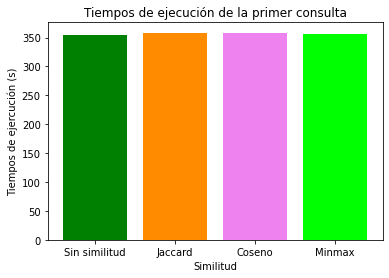

In [ ]:
plt.bar(x,y1,color=["green","darkorange","violet","lime"])
plt.title("Tiempos de ejecución de la primer consulta")
plt.xlabel("Similitud")
plt.ylabel("Tiempos de ejercución (s)")
plt.show()

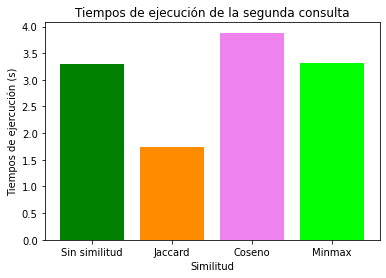

In [ ]:
plt.bar(x,y2,color=["green","darkorange","violet","lime"])
plt.title("Tiempos de ejecución de la segunda consulta")
plt.xlabel("Similitud")
plt.ylabel("Tiempos de ejercución (s)")
plt.show()

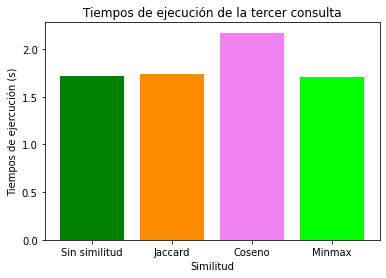

In [ ]:
plt.bar(x,y3,color=["green","darkorange","violet","lime"])
plt.title("Tiempos de ejecución de la tercer consulta")
plt.xlabel("Similitud")
plt.ylabel("Tiempos de ejercución (s)")
plt.show()

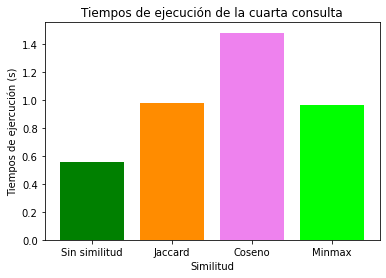

In [ ]:
plt.bar(x,y4,color=["green","darkorange","violet","lime"])
plt.title("Tiempos de ejecución de la cuarta consulta")
plt.xlabel("Similitud")
plt.ylabel("Tiempos de ejercución (s)")
plt.show()

In [ ]:
x = [6,39,200]
y1 = [tf4ss,tf2ss,tf3ss]
y2 = [tf4sj,tf2sj,tf3sj]
y3 = [tf4sc,tf2sc,tf3sc]
y4 = [tf4sm,tf2sm,tf3sm]

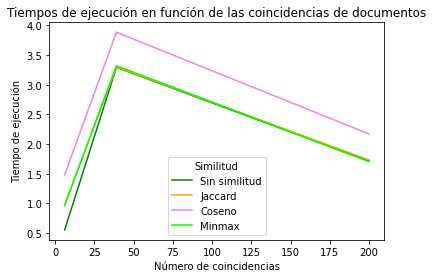

In [ ]:
plt.plot(x,y1,color="green",label="Sin similitud")
plt.plot(x,y2,color="orange",label="Jaccard")
plt.plot(x,y3,color="violet",label="Coseno")
plt.plot(x,y4,color="lime",label="Minmax")
plt.xlabel("Número de coincidencias")
plt.ylabel("Tiempo de ejecución")
plt.title("Tiempos de ejecución en función de las coincidencias de documentos")
plt.legend(loc="best",title="Similitud")
plt.show()

## Conclusión

Como podemos ver , las medidas de similitud tiene grandes ventajas para encontrar textos que tengan varias  cosas en común.Notamos que el indice inverso nos ayudo para ahorrar tiempo ya que no busca por todos los documentos, ya que va a haber casos en donde la similitud es cero, entonces no estamos haciendo fuerza bruta para la búsqueda de palabras similares.

Por lo que creemos que esta herramienta tiene grandes capacidades para ayudar a buscar textos similares ,en grandes cantidades de información,por ejemplo en el caso que nosotros hicimos podemos ver diagósticos anteriores y los tratameintos que se le dieron , esto si lo juntamos con información posterior a el tratamiento , podemos ver que tratamientos funcionan para encontrar mejores resultados para enfermedades y condiciones distintas.